In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

In [4]:
train_df.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


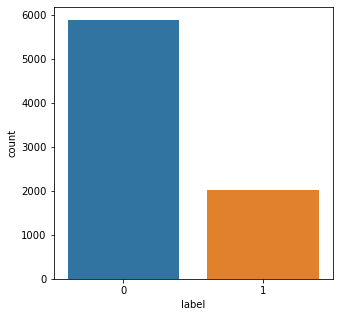

In [17]:
plt.figure(figsize=(5,5))
sns.countplot(train_df['label'])

In [6]:
from sklearn.utils import resample

In [7]:
good = train_df[train_df.label == 1]
bad = train_df[train_df.label == 0]

In [21]:
upsampled = resample(good,
                    n_samples=len(bad),
                    replace=True,
                    random_state=42)

In [27]:
upsampled_df = pd.concat([bad,upsampled]).reset_index()

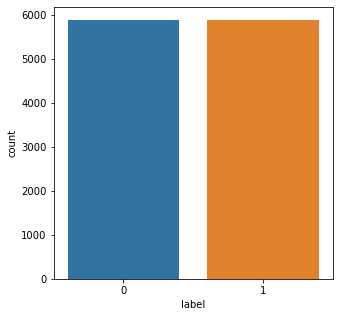

In [33]:
plt.figure(figsize=(5,5))
sns.countplot(upsampled_df['label'])

In [32]:
upsampled_df.head()

,index,id,label,tweet
0,0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,2,3,0,We love this! Would you go? #talk #makememorie...
3,3,4,0,I'm wired I know I'm George I was made that wa...
4,6,7,0,Happy for us .. #instapic #instadaily #us #son...


In [30]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [37]:
lemma = WordNetLemmatizer()
def create_data(df):
    clean_tweets = []
    
    for sent in tqdm(df['tweet']):
        sent = sent.lower()
        clean_sent = sent.translate(str.maketrans("",'',string.punctuation))
        words = word_tokenize(clean_sent)
        clean_words = [i for i in words if i not in stopwords.words('english')]
        lemma_words = [lemma.lemmatize(i) for i in clean_words]
        
        clean_tweets.append(lemma_words)
        
    return clean_tweets

In [38]:
train_tweets = create_data(upsampled_df)
test_tweets = create_data(test_df)

100%|██████████████████████████████████████████████████████████████████████████████| 1953/1953 [00:19<00:00, 98.11it/s]


In [39]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [74]:
y = upsampled_df.label
y = to_categorical(y,2)
num_classes = y.shape[1]

In [43]:
x_train,x_test,y_train,y_test = train_test_split(train_tweets,y,test_size=0.2,stratify=y)

In [46]:
unique_words = set()
len_max=0

for sent in tqdm(x_train):
    unique_words.update(sent)
    
    if len_max<len(sent):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████████| 9430/9430 [00:00<00:00, 591391.85it/s]

19111
37


In [56]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint,EarlyStopping
from livelossplot import PlotLossesKeras

In [48]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(x_train))

In [49]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_val = tokenizer.texts_to_sequences(test_tweets)

In [50]:
x_train = sequence.pad_sequences(x_train,maxlen=len_max)
x_test = sequence.pad_sequences(x_test,maxlen=len_max)
x_val = sequence.pad_sequences(x_val,maxlen=len_max)

In [51]:
from keras.models import Sequential
from keras.layers import LSTM,Embedding,Dense,Dropout

In [128]:
def create_model():
    model = Sequential()
    
    model.add(Embedding(len(list(unique_words)),80,input_length=len_max))
    model.add(LSTM(45,recurrent_dropout=0.5,dropout=0.5,return_sequences=True))
    model.add(LSTM(15,recurrent_dropout=0.5,dropout=0.5,return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(30,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes,activation='sigmoid'))
    
    return model

In [129]:
model = create_model()
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [130]:
callback = [EarlyStopping(patience=3,
                         monitor='val_accuracy'),
           PlotLossesKeras(),
           ModelCheckpoint('tmp_weights/epochs{epoch:02d}_acc_{val_accuracy:0.4f}',
                          monitor='val_accuracy',
                          save_weights_only=True,
                          save_best_only=True)]

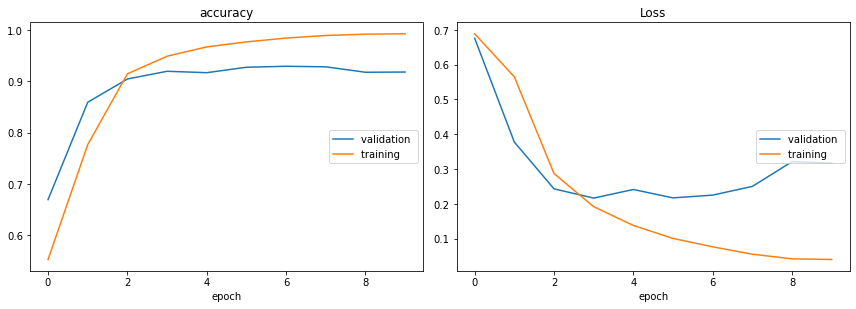

accuracy
	validation       	 (min:    0.669, max:    0.929, cur:    0.918)
	training         	 (min:    0.553, max:    0.993, cur:    0.993)
Loss
	validation       	 (min:    0.216, max:    0.676, cur:    0.317)
	training         	 (min:    0.040, max:    0.689, cur:    0.040)


In [131]:
h = model.fit(x_train,y_train,
             validation_data=(x_test,y_test),
             epochs=10,
                 batch_size=256,
             callbacks=callback)

In [132]:
y_pred = model.predict(x_val)
y_pred = [np.argmax(i) for i in y_pred]

In [133]:
sub = pd.DataFrame({'id':test_df.id,'label':y_pred})

In [134]:
sub.to_csv("submission.csv",index=False)

In [135]:
model.save('Models/final_model.h5')

model_json = model.to_json()
with open('Models/final_model.json','w') as file:
    file.write(model_json)